In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import torch
import matplotlib.pyplot as plt
from botorch.utils.sampling import draw_sobol_samples 
import numpy as np 
import json

import sys
sys.path.append('..')
import sample_utilities.samples as samples
import uuid

import scipy
from scipy.stats.qmc import Sobol
from scipy.stats import qmc

import pandas as pd
import seaborn as sns

## Load bounds

In [29]:
target_volume = 10000

In [31]:
with open('Mesoporous_constants_APS_batch.json', 'r') as f:
    constants = json.load(f)


ctab_lower_vf = constants['ctab']['minimum_mass']/constants['ctab']['stock_concentration_mg_uL']/target_volume  
f127_lower_vf = constants['f127']['minimum_mass']/constants['f127']['stock_concentration_mg_uL']/target_volume

ctab_upper_vf = constants['ctab']['maximum_mass']/constants['ctab']['stock_concentration_mg_uL']/target_volume
f127_upper_vf = constants['f127']['maximum_mass']/constants['f127']['stock_concentration_mg_uL']/target_volume

lower_bounds = [constants['TEOS']['minimum_volume_fraction'],
                constants['ammonia']['minimum_volume_fraction'],
                constants['ethanol']['minimum_volume_fraction'],
                constants['ctab']['minimum_mass'],
                constants['f127']['minimum_mass']]

upper_bounds = [constants['TEOS']['maximum_volume_fraction'],
                constants['ammonia']['maximum_volume_fraction'],
                constants['ethanol']['maximum_volume_fraction'],
                constants['ctab']['maximum_mass'],
                constants['f127']['maximum_mass']]

In [32]:
ctab_upper_vf

0.6666666666666667

In [34]:
n_samples = 80

In [35]:
def constrained_sobol_sampling_rejection(n: int, num_samples: int, m_samples = 8, seed: int = None):
    """
    Generates Sobol samples in n dimensions satisfying:
    a) Sum of all components = 1.0
    b) Last component (nth dim) is in [0.4, 1.0]

    Uses rejection sampling: Generates a large pool and filters valid samples.

    Args:
        n (int): Number of dimensions.
        num_samples (int): Number of valid samples to return.
        pool_size (int): Number of initial samples to generate before filtering.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        torch.Tensor: (num_samples, n) tensor of valid samples.
    """
    if seed is not None:
        torch.manual_seed(seed)

    valid_samples = []
    
    while len(valid_samples) < num_samples:
        print('Number valid samples: ', len(valid_samples))
        # Generate Sobol samples in [0,1]^n
        #sobol_samples = draw_sobol_samples(bounds=torch.tensor([[0.0] * n, [1.0] * n]), n=pool_size, q=1).squeeze(1)
        sampler = Sobol(d=n, seed = seed)
        sampled_points = sampler.random_base2(m_samples)
    
        sampled_volume_fractions = qmc.scale(sampled_points, lower_bounds, upper_bounds)


        for i in range(len(sampled_volume_fractions)):
            teos_vol_frac = sampled_volume_fractions[i, 0]
            ammonia_vol_frac = sampled_volume_fractions[i, 1]
            ethanol_vol_frac = sampled_volume_fractions[i, 2]
            # convert surfactant mass to volumes
            ctab_mass = sampled_volume_fractions[i, 3]
            f127_mass = sampled_volume_fractions[i, 4]
    
            ctab_vol_frac = ctab_mass/constants['ctab']['stock_concentration_mg_uL']/target_volume
            f127_vol_frac = f127_mass/constants['f127']['stock_concentration_mg_uL']/target_volume
    
            water_from_surfactant_vf = ctab_vol_frac+f127_vol_frac
    
            
    
            water_min_vf = constants['water']['minimum_volume_fraction']
    
            # water that needs to be delivered to meet minimum volume fraction
            water_min_vf_delivered = max(water_min_vf-water_from_surfactant_vf, 0)
    
            max_other_components = 1 - water_min_vf_delivered

            print(max_other_components)
    
    
            sum_nonwater_additions = teos_vol_frac + ammonia_vol_frac + ethanol_vol_frac + ctab_vol_frac + f127_vol_frac
            sum_water_free_additions = teos_vol_frac + ammonia_vol_frac + ethanol_vol_frac
            if sum_nonwater_additions < max_other_components:

                water_vol_frac = 1 - sum_water_free_additions
                sample = [teos_vol_frac, ammonia_vol_frac, ethanol_vol_frac, ctab_mass, f127_mass, water_vol_frac]
                
                print('found valid sample: ', sample)
                valid_samples.append(sample)

    return valid_samples[0:num_samples]


In [36]:
baseline_samples = constrained_sobol_sampling_rejection(5, n_samples, m_samples= 7)

Number valid samples:  0
1
0.8472825769955914
found valid sample:  [np.float64(0.006621358861215412), np.float64(0.053621985306963334), np.float64(0.20220202952623367), np.float64(20.93964452855289), np.float64(3.842473402619362), np.float64(0.7375546263055877)]
1
1
1
1
0.9892147929097215
found valid sample:  [np.float64(0.01200164359807968), np.float64(0.04124686700291932), np.float64(0.27188622634857895), np.float64(27.3203641269356), np.float64(53.539516031742096), np.float64(0.674865263050422)]
1
1
found valid sample:  [np.float64(0.04488621058361605), np.float64(0.01979895246215165), np.float64(0.25582813974469903), np.float64(61.119833532720804), np.float64(23.16279374063015), np.float64(0.6794866972095333)]
1
1
1
found valid sample:  [np.float64(0.048410389123950154), np.float64(0.047602432062849406), np.float64(0.3838143948465586), np.float64(22.06649853847921), np.float64(116.43966464325786), np.float64(0.5201727839666419)]
0.9769899285087983
found valid sample:  [np.float64(0

In [51]:
teos_vf = []
ammonia_vf = []
ethanol_vf = []
ctab_vf = []
f127_vf = []
water_vf = []

for sample in baseline_samples:
    sample_sum = 0
    teos_vf.append(sample[0])
    ammonia_vf.append(sample[1])
    ethanol_vf.append(sample[2])
    ctab_vf.append(sample[3])
    f127_vf.append(sample[4])
    water_vf.append(sample[5])
    for entry in sample:
        sample_sum += entry
    print('Sample sum: ', sample_sum)


Sample sum:  25.78211793117225
Sample sum:  81.8598801586777
Sample sum:  85.28262727335094
Sample sum:  139.50616318173707
Sample sum:  106.28981531970203
Sample sum:  149.90065163373947
Sample sum:  53.705294555053115
Sample sum:  96.35973601974547
Sample sum:  181.16906050965187
Sample sum:  173.6346930582076
Sample sum:  230.9291699193418
Sample sum:  200.04580645263195
Sample sum:  115.75433795712888
Sample sum:  182.60765468142927
Sample sum:  162.44101668149233
Sample sum:  177.63243224844337
Sample sum:  96.96024663187563
Sample sum:  224.79605294205248
Sample sum:  103.4695579521358
Sample sum:  244.38481015525758
Sample sum:  74.82104277610779
Sample sum:  126.63445527106524
Sample sum:  98.68170128576458
Sample sum:  85.7748523298651
Sample sum:  165.90390928462148
Sample sum:  73.82713765278459
Sample sum:  58.016001269221306
Sample sum:  92.47368585690856
Sample sum:  305.26486746408045
Sample sum:  276.8412395324558
Sample sum:  45.95914462953806
Sample sum:  129.08825865

In [38]:
len(baseline_samples)

80

In [59]:
raw_vfs = pd.DataFrame({'teos_vf':teos_vf, 'ammonia_vf':ammonia_vf, 'ethanol_vf':ethanol_vf, 'ctab_vf':ctab_vf, 'f127_vf':f127_vf, 'water_vf':water_vf})

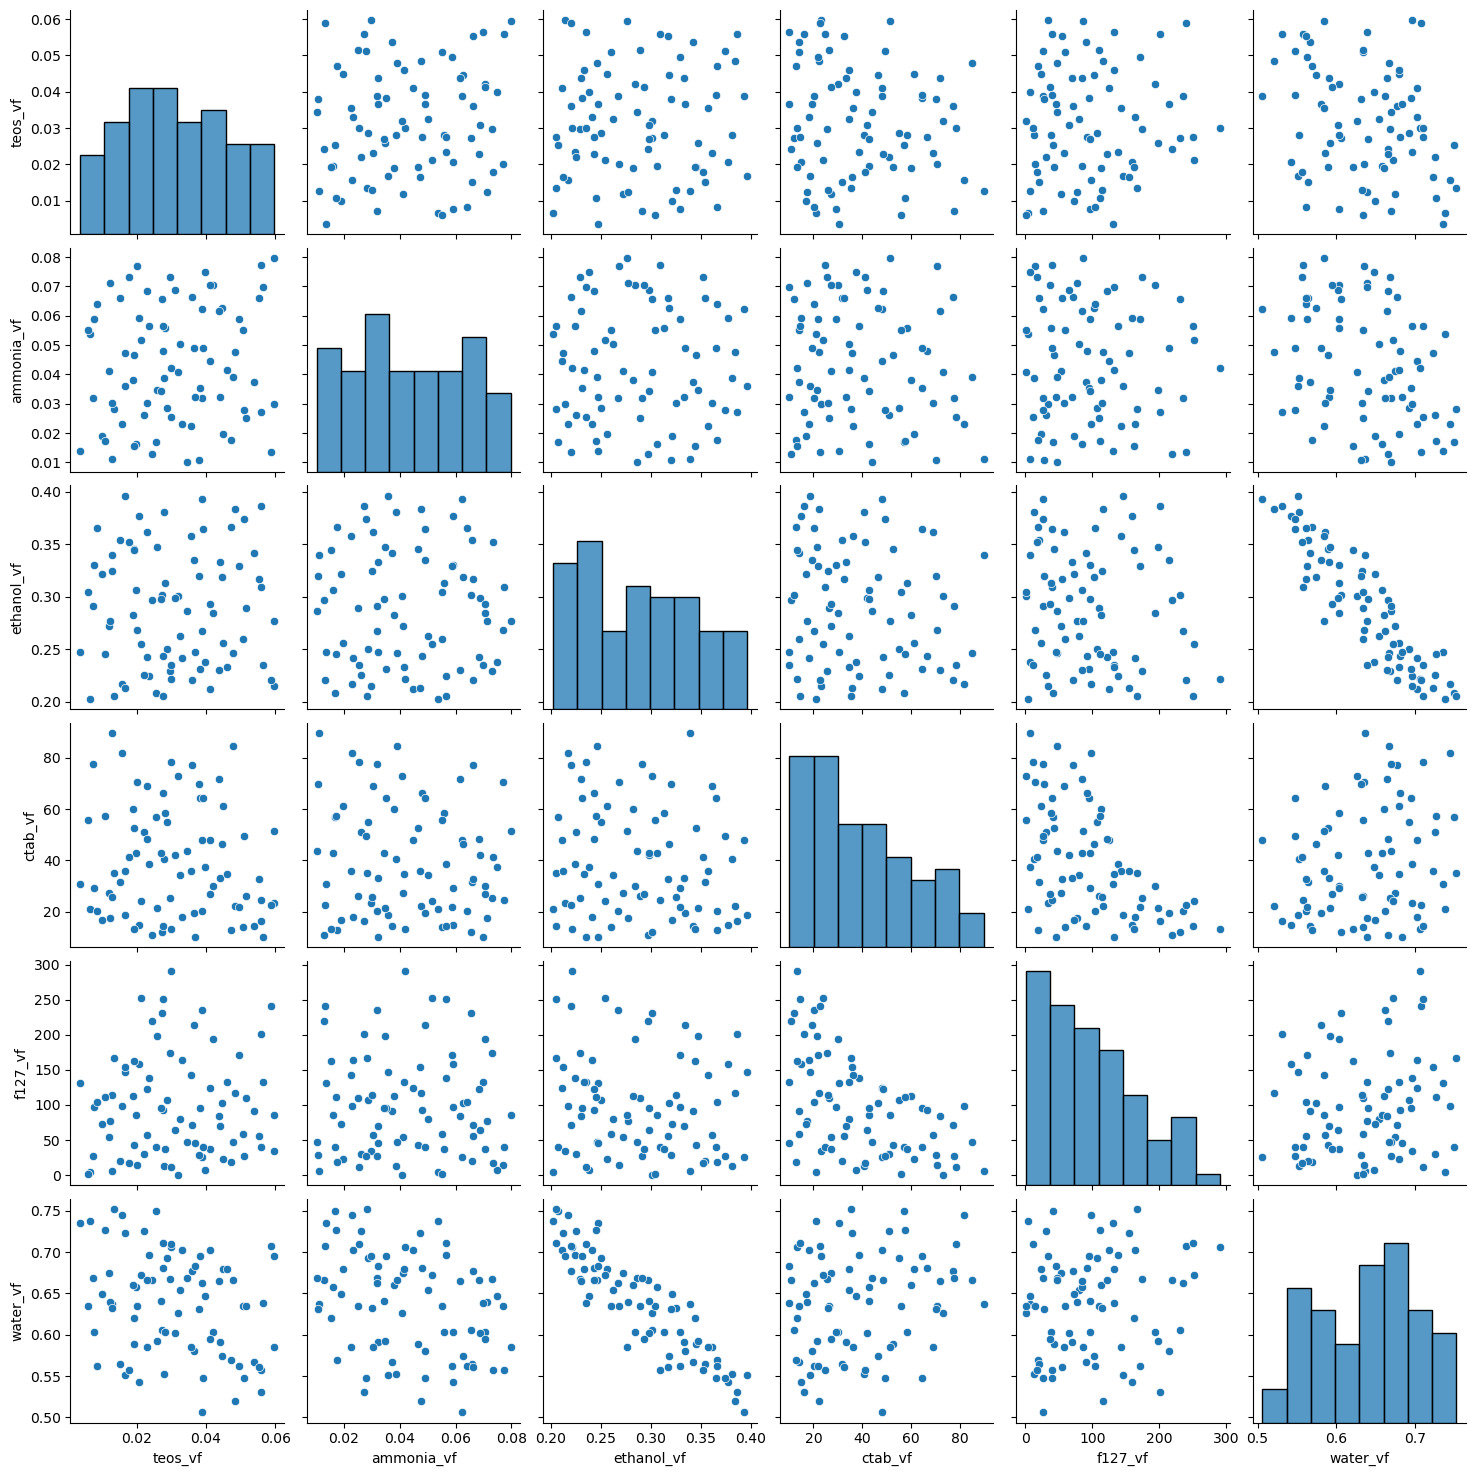

In [60]:
sns.pairplot(raw_vfs)

In [61]:
uuid_vals = [uuid.uuid4() for val in baseline_samples]
teos_volume = [target_volume*entry[0] for entry in baseline_samples]

In [62]:
samples_gen = []
for i in range(len(baseline_samples)):
    row = baseline_samples[i]
    sample = samples.MesoporousSample(target_volume=target_volume, reactant_fp='Mesoporous_constants_APS.json', teos_vol_frac=row[0], ammonia_vol_frac=row[1], ethanol_vol_frac=row[2], ctab_mass=row[3], f127_mass=row[4], water_vol_frac=row[5])
    sample.calculate_reactant_volumes()
    #sample.calculate_silica_mass_concentration()
    #sample.calculate_silica_mass_fraction()
    #sample.calculate_dilution_volumefraction(target_dilution)
    samples_gen.append(sample)
    print('final etoh vol: ', sample.ethanol_volume)

TEOS ETOH:  122.49513893248515
Solvent etoh total:  122.49513893248515
final etoh vol:  1899.5251563298516
TEOS ETOH:  222.03040656447408
Solvent etoh total:  222.03040656447408
final etoh vol:  2496.831856921315
TEOS ETOH:  830.3948957968969
Solvent etoh total:  830.3948957968969
final etoh vol:  1727.8865016500936
TEOS ETOH:  895.5921987930778
Solvent etoh total:  895.5921987930778
final etoh vol:  2942.5517496725083
TEOS ETOH:  995.1194956942927
Solvent etoh total:  995.1194956942927
final etoh vol:  2423.655952881323
TEOS ETOH:  665.5394777895417
Solvent etoh total:  665.5394777895417
final etoh vol:  1534.89637670503
TEOS ETOH:  517.9685096417088
Solvent etoh total:  517.9685096417088
final etoh vol:  3290.473863187013
TEOS ETOH:  357.22002332075493
Solvent etoh total:  357.22002332075493
final etoh vol:  3093.254739968339
TEOS ETOH:  290.7233627110254
Solvent etoh total:  290.7233627110254
final etoh vol:  1877.875639352249
TEOS ETOH:  760.2665811995976
Solvent etoh total:  760.2

In [63]:
sample.water_volume

np.float64(208.58275445954223)

In [72]:
uuid_vals = []
teos_volumes = []
ammonia_volumes = []
ethanol_volumes = []
water_volumes = []
ctab_volumes = []
f127_volumes = []
sample_names = []

for i, sample in enumerate(samples_gen):
    sample_names.append(f'SobolBatch_{i+1}')
    uuid_vals.append(uuid.uuid4())
    teos_volumes.append(sample.teos_volume)
    ammonia_volumes.append(sample.ammonia_volume)
    ethanol_volumes.append(sample.ethanol_volume)
    water_volumes.append(sample.water_volume)
    ctab_volumes.append(sample.ctab_volume)
    f127_volumes.append(sample.f127_volume)\

    total_volume = sample.teos_volume+sample.ammonia_volume + sample.water_volume + sample.ethanol_volume + sample.ctab_volume + sample.f127_volume
    print(f'Total volume sample SobolBaseline_{i+1}: {total_volume}')



Total volume sample SobolBaseline_1: 10000.0
Total volume sample SobolBaseline_2: 10000.0
Total volume sample SobolBaseline_3: 10000.0
Total volume sample SobolBaseline_4: 10000.0
Total volume sample SobolBaseline_5: 10000.0
Total volume sample SobolBaseline_6: 10000.0
Total volume sample SobolBaseline_7: 10000.0
Total volume sample SobolBaseline_8: 10000.0
Total volume sample SobolBaseline_9: 10000.0
Total volume sample SobolBaseline_10: 10000.0
Total volume sample SobolBaseline_11: 10000.0
Total volume sample SobolBaseline_12: 10000.0
Total volume sample SobolBaseline_13: 10000.0
Total volume sample SobolBaseline_14: 10000.0
Total volume sample SobolBaseline_15: 10000.0
Total volume sample SobolBaseline_16: 10000.0
Total volume sample SobolBaseline_17: 10000.0
Total volume sample SobolBaseline_18: 10000.0
Total volume sample SobolBaseline_19: 10000.0
Total volume sample SobolBaseline_20: 10000.0
Total volume sample SobolBaseline_21: 10000.0
Total volume sample SobolBaseline_22: 10000

In [119]:
sample_table = pd.DataFrame({'sample_name':sample_names,
                             'uuid':uuid_vals,
                             'teos_volume':teos_volumes,
                             'ammonia_volume':ammonia_volumes,
                             'water_volume':water_volumes,
                             'ethanol_volume':ethanol_volumes,
                             'ctab_volume':ctab_volumes,
                             'F127_volume':f127_volumes
                            })

In [120]:
sample_table

,sample_name,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,ctab_volume,F127_volume
0,SobolBatch_1,4c0400c8-3631-42ca-92f6-6cd1d0f0b0d3,188.708728,536.219853,5902.720493,1899.525156,1395.976302,76.849468
1,SobolBatch_2,fe05e774-5c92-4248-8d59-74afda65ee1a,342.046843,412.468670,3856.504701,2496.831857,1821.357608,1070.790321
2,SobolBatch_3,aab54b4e-1d8c-4262-a158-e9cdf14edbff,1279.257002,197.989525,2256.955528,1727.886502,4074.655569,463.255875
3,SobolBatch_4,51558b9d-5018-4c0c-bca8-16b264207ef9,1379.696090,476.024321,1401.834644,2942.551750,1471.099903,2328.793293
4,SobolBatch_5,ae8570a4-85c6-4903-bfa6-852670463b4d,1533.021926,374.232377,2899.190459,2423.655953,948.718541,1821.180744
...,...,...,...,...,...,...,...,...
75,SobolBatch_76,c60e6fcd-c457-40d8-9d2b-bcf72793a4c1,1114.331675,489.195076,399.276870,2923.317598,4279.141697,794.737084
76,SobolBatch_77,bda382f7-2b73-4941-ac9e-9a794d0e2ed3,507.961463,732.685161,2484.911837,3192.106947,2749.532188,332.802404
77,SobolBatch_78,0cc6035c-a149-4764-9896-a26aecb380ff,1410.262837,587.635686,734.421605,2377.659058,1454.000166,3436.020646
78,SobolBatch_79,f9d13a27-bbf3-4a4b-add5-24313ff8742b,309.837529,172.560101,1203.710347,2253.049331,3830.844133,2229.998561


In [121]:
## Insert controls
def insert_row(df, new_row, index):
    """
    Inserts a new row into a DataFrame at a specific index.

    Parameters:
    df (pd.DataFrame): The original DataFrame.
    new_row (dict): The row to insert, as a dictionary.
    index (int): The position to insert the new row.

    Returns:
    pd.DataFrame: A new DataFrame with the inserted row.
    """
    df1 = df.iloc[:index]  # Rows before insertion
    df2 = pd.DataFrame([new_row])  # New row as DataFrame
    df3 = df.iloc[index:]  # Rows after insertion

    return pd.concat([df1, df2, df3]).reset_index(drop=True)

In [122]:
n_controls = 6

control_teos_vol = 739.6697222781366
control_ammonia_vol = 427.0686506293714	
control_water_vol = 1856.7212829769896
control_ethanol_vol = 1706.73249814054
control_ctab_vol = 4027.093018094699
control_f127_vol = 1242.7148278802633

controls = []
for i in range(n_controls):
    controls.append({'sample_name':f'SobolBatch_control_{i+1}', 'uuid':uuid.uuid4(), 'teos_volume':control_teos_vol, 'ammonia_volume':control_ammonia_vol, 'water_volume':control_water_vol, 'ethanol_volume':control_ethanol_vol, 'ctab_volume':control_ctab_vol, 'F127_volume':control_f127_vol})

control_inds = [0, 1, 2, 28, 52, 76]

for i, control in enumerate(controls):
    sample_table = insert_row(sample_table, control, control_inds[i])


In [123]:
controls

[{'sample_name': 'SobolBatch_control_1',
  'uuid': UUID('5dcea3d4-4afc-4389-afbd-03b4640e2860'),
  'teos_volume': 739.6697222781366,
  'ammonia_volume': 427.0686506293714,
  'water_volume': 1856.7212829769896,
  'ethanol_volume': 1706.73249814054,
  'ctab_volume': 4027.093018094699,
  'F127_volume': 1242.7148278802633},
 {'sample_name': 'SobolBatch_control_2',
  'uuid': UUID('5219bd08-7689-483d-92e8-4162d16d8379'),
  'teos_volume': 739.6697222781366,
  'ammonia_volume': 427.0686506293714,
  'water_volume': 1856.7212829769896,
  'ethanol_volume': 1706.73249814054,
  'ctab_volume': 4027.093018094699,
  'F127_volume': 1242.7148278802633},
 {'sample_name': 'SobolBatch_control_3',
  'uuid': UUID('27a11227-cf1f-4da7-8875-26bbc1e11a05'),
  'teos_volume': 739.6697222781366,
  'ammonia_volume': 427.0686506293714,
  'water_volume': 1856.7212829769896,
  'ethanol_volume': 1706.73249814054,
  'ctab_volume': 4027.093018094699,
  'F127_volume': 1242.7148278802633},
 {'sample_name': 'SobolBatch_contr

In [125]:
sample_table

,sample_name,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,ctab_volume,F127_volume
0,SobolBatch_control_1,5dcea3d4-4afc-4389-afbd-03b4640e2860,739.669722,427.068651,1856.721283,1706.732498,4027.093018,1242.714828
1,SobolBatch_control_2,5219bd08-7689-483d-92e8-4162d16d8379,739.669722,427.068651,1856.721283,1706.732498,4027.093018,1242.714828
2,SobolBatch_control_3,27a11227-cf1f-4da7-8875-26bbc1e11a05,739.669722,427.068651,1856.721283,1706.732498,4027.093018,1242.714828
3,SobolBatch_1,4c0400c8-3631-42ca-92f6-6cd1d0f0b0d3,188.708728,536.219853,5902.720493,1899.525156,1395.976302,76.849468
4,SobolBatch_2,fe05e774-5c92-4248-8d59-74afda65ee1a,342.046843,412.468670,3856.504701,2496.831857,1821.357608,1070.790321
...,...,...,...,...,...,...,...,...
81,SobolBatch_76,c60e6fcd-c457-40d8-9d2b-bcf72793a4c1,1114.331675,489.195076,399.276870,2923.317598,4279.141697,794.737084
82,SobolBatch_77,bda382f7-2b73-4941-ac9e-9a794d0e2ed3,507.961463,732.685161,2484.911837,3192.106947,2749.532188,332.802404
83,SobolBatch_78,0cc6035c-a149-4764-9896-a26aecb380ff,1410.262837,587.635686,734.421605,2377.659058,1454.000166,3436.020646
84,SobolBatch_79,f9d13a27-bbf3-4a4b-add5-24313ff8742b,309.837529,172.560101,1203.710347,2253.049331,3830.844133,2229.998561


In [126]:
vial_volume = 17000
cols = ['teos_volume', 'ammonia_volume', 'ethanol_volume', 'water_volume', 'ctab_volume', 'F127_volume']
for col in cols:
    total_volume = sample_table[col].sum()
    print(f'Total volume {col} required: {total_volume/1000}')
    n_vials = total_volume/vial_volume
    print(f'Volume for {col}: {total_volume}, vials required: {n_vials}')

Total volume teos_volume required: 75.30909493331029
Volume for teos_volume: 75309.09493331029, vials required: 4.429946760782959
Total volume ammonia_volume required: 37.19806920653209
Volume for ammonia_volume: 37198.06920653209, vials required: 2.1881217180312995
Total volume ethanol_volume required: 195.1447742198345
Volume for ethanol_volume: 195144.77421983448, vials required: 11.479104365872617
Total volume water_volume required: 156.162957548361
Volume for water_volume: 156162.95754836098, vials required: 9.186056326374175
Total volume ctab_volume required: 232.872579695036
Volume for ctab_volume: 232872.579695036, vials required: 13.69838704088447
Total volume F127_volume required: 163.31252439692616
Volume for F127_volume: 163312.52439692616, vials required: 9.606619082172127


In [127]:
sample_table.to_csv('Mesoporous_SobolBaseline_APS_BatchMode_3_29_25.csv')